# To Do:

1. Check for Null or Missing Values https://chartio.com/resources/tutorials/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe/

2. https://github.com/jupyter-widgets/ipywidgets/issues/1849 fix the ipyWidget layout

3. http://mithra.eecs.umich.edu/demo/ranking/

scale, standardize, normalize https://medium.com/@jeffhale/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02?source=email-454c9b4e912a-1565755578405-digest.reader------0-49------------------07c46a51_14c4_42e4_aaa6_5559770cfa1a-1&sectionName=top


Pandas CrossTab https://pbpython.com/pandas-crosstab.html
Pandas Styles https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

Note: it makes sense to one hot encode as part of preprocess *before* viewing correlations?
Improve the heatmap:
https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

////
Use this as part of the class to print statistics on any dropdown. 
print ("Mimimum FYA:", dp.get_df()['ZFYA'].max())
print ("Maximum FYA:", dp.get_df()['ZFYA'].min())
print ("Maximum FYA:", dp.get_df()['ZFYA'].mean())
Type
Missing Values
Number of unique entries
Other relevant Data>
/////
https://stackoverflow.com/questions/45286696/how-to-display-dataframe-next-to-plot-in-jupyter-notebook/45287049

# About the Law School Admission data
The Law School Admission Council conducted a survey across 163 law schools in the United States

https://www.luciusbynum.com/project/counterfactual-fairness/


It contains information on 21,790 law students such as:
- Entrance exam scores (LSAT)
- Grade-point average (GPA) collected prior to law school,
- sander_index' - Sander proposes combining the LSAT and undergraduate GPA into a single
weighted average, using weights that correspond roughly to those used in many law schools. We refer to this average as the “Sander Index.” Because the units of this index are difficult to interpret, we convert it to a percentile score. This score ranges from 0 to 100, and represents the percentage of law school matriculants with lower index scores. That is, a student with a percentile score of 75 has better academic credentials than three quarters of law school matriculants, but worse credentials than the remaining quarter. see http://public.econ.duke.edu/~hf14/teaching/povertydisc/readings/rothstein_yoon_2007.pdf

- first_pf - Whether or not the BAR exam was passed or failed
- region_first
- First year average grade (FYA) - Label used for training purposes
                      
In this scenario we will use the data to predict the success of prospective students in their first year of law school. We can imagine such a model being used by an admissions department as part of deciding who to accept into their program.
                      
The school would also like to make sure these predictions are not biased by an individual’s race and sex. However, the LSAT, GPA, and FYA scores, may be biased due to social factors. 

we generate predictors Y for a logistic regression model, ranking the output. 

# About the Compas data

# About the Loan approval Data

https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/
    

# Libraries

In [1]:
#pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install 
#pip install autopep8
#jupyter nbextension enable --py widgetsnbextension
#python -m pip install git+https://github.com/dssg/aequitas.git
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas_profiling
from sklearn import datasets
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from io import StringIO
import pprint
import pandas_profiling
import re
import random
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display, clear_output, HTML
from aequitas.preprocessing import preprocess_input_df
import math
from collections import Counter



#$ pip install ipyupload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from ipyupload import FileUpload


from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important;}</style>"))

# Pre-process the data
Machine learning algorithms require numerical inputs. Our features will come in various forms. Some will be continuous, others categorical (in numeric or text format). Machine learning algorithms cannot work with variables in text form, we must perform certain preprocessing steps to get our data in the right format.


- Identify the protected attributes and the label (y) in the dataset so that these may be split  out when necessary
- Remove any obviously unnecessary columns
- Review any correlations and remove any obviously correlated input columns
- Standardise/normalise or scale any necessary numerical features
- Review protected attributes and
    * Consolidate values for better representation e.g Race => White and Non-White
    * Rename any necessary category/Text values (Label Encoding)
    * Change column data types of category/text data to 'int' (Label Encoding)
- one-hot encode the categorical features.
- Decide if the model will be trained with or without the protected attributes






In [112]:
class data_pre_process_UI():

    def __init__(self):
        self.df = pd.DataFrame()
        self.feature_set_with_y = self.df
        self.feature_set = self.df
        self.feature_set_final = self.feature_set
        self.feature_set_final_without_protected = self.feature_set
        self.HIGH_RANGE_POSITIVE = True
        self.renamed = {}
        self.referenceNames = {}
       

        self.X = None  # input features for model training
        self.y = None  # label for model training
        # A dictionary, mapping the protected group with a protected value
        self.protectedGroup = {}
        # A dictionary, mapping the protected group with a protected value
        self.nonProtectedGroup = {}

        self.style = {'description_width': 'initial'}
        self.layout = {'width': '500px'}
        self.layout_short = {'width': '300px'}
        

        self.fileUploader = FileUpload(accept='.csv',
                                       multiple=False,
                                       disabled=False,
                                       style_button='color: darkblue; background-color: lightsalmon; width: 180px;',
                                       compress_level=9
                                       )

        self.selectXAttributes = widgets.SelectMultiple(
            options=self.df.columns.values,
            # value=[self.df.columns.values[1]],
            description='Possible Input Features',
            disabled=False,
            style=self.style,
            layout=self.layout
        )

        self.selectProtectedAttributes = widgets.SelectMultiple(
            options=self.df.columns.values,
            # value=[self.df.columns.values[1]],
            description='Protected Attribute(s)',
            disabled=False,
            style=self.style,
            layout=self.layout
        )

        self.selectAttributeToMerge = widgets.Dropdown(
            description='Select Attribute',
            value=None,
            disabled=False,
            style=self.style,
            layout=self.layout
        )

        self.selectImpact = widgets.RadioButtons(
            options={'A Positive impact on the individual in question': 1,
                     'A Negative impact on the individual in question': 2},
            description='An output in the high range will have:',
            disabled=False,
            style=self.style,
            layout=self.layout
        )
        

        def on_impact_selected(change):
            if (change['new'] == 1):
                self.HIGH_RANGE_POSITIVE = True
            if (change['new'] == 2):
                self.HIGH_RANGE_POSITIVE = False
            self.view_protected(self.selectProtectedAttributes.value, self.selectYAttribute.value)
            

        self.selectImpact.observe(on_impact_selected, names='value')
        

        self.newNameForValue = widgets.Text(
            description='New Value',
            disabled=False,
            layout=self.layout_short,
            tooltip='enter the new value name',
            style = self.style
        )
        
        
        self.nameForProtectedGroup = widgets.Text(
            description='Reference Name',
            disabled=False,
            layout=self.layout_short,
            tooltip='Save a reference name for the value e.g "protected" or the original name',
            style = self.style
        )

        self.choosen_attribute_values = widgets.SelectMultiple(
            description='Select values to merge',
            disabled=False,
            style=self.style,
            layout=self.layout_short
        )



        self.rename_value_button = widgets.Button(
            description='Rename',
            disabled=False,
            button_style='',  # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Click me',
            icon='check'
        )

        self.change_column_type_button = widgets.Button(
            description='Change',
            disabled=False,
            button_style='',  # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Click me',
            icon='check'
        )

        self.one_hot_encode_button = widgets.Button(
            description='Run',
            disabled=False,
            button_style='',  # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Click me',
            icon='check'
        )

        self.selectYAttribute = widgets.Dropdown(
            options=self.df.columns.values,
            # value=self.df.columns.values[1],
            description='Output Label(y):',
            disabled=False,
            style=self.style,
            layout=self.layout
        )

        self.selectXAttributesToDrop = widgets.SelectMultiple(
            options=self.feature_set.columns.values,
            description='Select attributes to Drop',
            disabled=False,
            style=self.style,
            layout=self.layout
        )

        self.selectXAttributesToCorrelate = widgets.SelectMultiple(
            options=self.feature_set.columns.values,
            description='Select attribute(s)',
            disabled=False,
            style=self.style,
            layout=self.layout
        )

        self.selectXAttributesToHotEncode = widgets.SelectMultiple(
            options=self.feature_set_final.columns.values,
            description='Select attributes to Hot Encode',
            disabled=False,
            style=self.style,
            layout=self.layout
        )

        self.selectProtected = widgets.ToggleButtons(
            options=['Yes', 'No'],
            value='Yes',
            description='Select:',
            disabled=False,
            button_style='',  # 'success', 'info', 'warning', 'danger' or ''
            tooltips=['Tooltip1', 'Tooltip2'],
            style=self.style
        )

        self.selectColumnType = widgets.Dropdown(
            description='Change Column data type',
            options=['str', 'int'],
            value=None,
            disabled=False,
            style=self.style,
            layout=self.layout
        )

        self.rename_value_button.on_click(self.on_rename_button_clicked)
        self.change_column_type_button.on_click(
            self.on_change_column_type_button_clicked)
        self.one_hot_encode_button.on_click(self.one_hot_encode_button_clicked)
        self.fileUploader.observe(self.on_new_file_upload, names='value')

        self.outputA = widgets.interactive_output(self.outputFunctionA, {
            'fileUploader_value': self.fileUploader})
           # 'selectXAttribute_values': self.selectXAttributes,
           # 'selectProtectedAttribute_values': self.selectProtectedAttributes,
           # 'selectYAttribute_values': self.selectYAttribute,
           # 'selectXAttributesToDrop_values': self.selectXAttributesToDrop})

        self.outputB = widgets.interactive_output(self.outputFunctionB, {
            'selectXAttributes_values': self.selectXAttributes,
            'selectProtectedAttributes_values': self.selectProtectedAttributes,
            'selectYAttribute_values': self.selectYAttribute})

        self.viewProtectedOut = widgets.interactive_output(self.view_protected, {
            'selectProtectedAttributes_values': self.selectProtectedAttributes,
            'selectYAttribute_values': self.selectYAttribute})

        self.mergeOut = widgets.interactive_output(self.merge_attribute, {
            'selectProtectedAttributes_values': self.selectProtectedAttributes,
            'selectAttributeToMerge_value': self.selectAttributeToMerge})
        
        # self.mergeOutMerge = widgets.Output(layout={})

        self.correlationsOut = widgets.interactive_output(self.view_correlations, {
            'selectXAttributesToCorrelate_values': self.selectXAttributesToCorrelate,
            'selectYAttribute_values': self.selectYAttribute})
        
        self.correlationsGraphOut = widgets.Output(layout={})

        self.dropColOut = widgets.interactive_output(self.dropCol, {
            'selectXAttributesToDrop_values': self.selectXAttributesToDrop})

        self.HotEncodeOut = widgets.interactive_output(self.Hot_Encode_Col, {
            'selectXAttributesToHotEncode_values': self.selectXAttributesToHotEncode})

        self.protectedOut = widgets.interactive_output(
            self.withOrWithoutProtected, {'selectProtected_value': self.selectProtected})

    def describe_numeric_1d(series, **kwargs):
        """Compute summary statistics of a numerical (`TYPE_NUM`) variable (a Series).
        Also create histograms (mini an full) of its distribution.
        Parameters
        ----------
        series : Series
            The variable to describe.
        Returns
        -------
        Series
        The description of the variable as a Series with index being stats keys.
        NOTE: copied and modified from pandas_profiling source code
        """
        # Format a number as a percentage. For example 0.25 will be turned to 25%.
        _percentile_format = "{:.0%}"
        stats = dict()
        stats['type'] = base.TYPE_NUM
        stats['mean'] = series.mean()
        stats['std'] = series.std()
        stats['variance'] = series.var()
        stats['min'] = series.min()
        stats['max'] = series.max()
        stats['range'] = stats['max'] - stats['min']
        # To avoid to compute it several times
        _series_no_na = series.dropna()
        for percentile in np.array([0.05, 0.25, 0.5, 0.75, 0.95]):
            # The dropna() is a workaround for https://github.com/pydata/pandas/issues/13098
            stats[_percentile_format.format(
                percentile)] = _series_no_na.quantile(percentile)
        stats['iqr'] = stats['75%'] - stats['25%']
        stats['kurtosis'] = series.kurt()
        stats['skewness'] = series.skew()
        stats['sum'] = series.sum()
        stats['mad'] = series.mad()
        stats['cv'] = stats['std'] / stats['mean'] if stats['mean'] else np.NaN
        stats['n_zeros'] = (len(series) - np.count_nonzero(series))
        stats['p_zeros'] = stats['n_zeros'] * 1.0 / len(series)
        # Histograms
        stats['histogram'] = histogram(series, **kwargs)
        stats['mini_histogram'] = mini_histogram(series, **kwargs)
        return pd.Series(stats, name=series.name)
    
    
    #################################################################################################
    #  
    # 
    #################################################################################################
    
    def merge_attribute(self, 
                        selectProtectedAttributes_values, 
                        selectAttributeToMerge_value):
        protected = []
        try:
            
            for feature in selectProtectedAttributes_values:
                protected.append(feature)
            #modify here to read from x values and y value
                
            self.selectAttributeToMerge.options = protected
            self.choosen_attribute_values.options = self.feature_set[self.selectAttributeToMerge.value].unique()
            colType = self.feature_set[self.selectAttributeToMerge.value].dtype
            
            with self.mergeOut:
                print (" ")
                print("Attribute data type:", colType)

        except:
            print("**Protected attribut merge not yet generated**")

    
    #################################################################################################
    #  
    # 
    #################################################################################################
    def on_rename_button_clicked(self, b):
        with self.mergeOut:
            clear_output(wait=True)
            colTypeCast = type(self.choosen_attribute_values.value[0])
            if self.selectAttributeToMerge.value not in self.renamed:
                self.renamed[self.selectAttributeToMerge.value] = {}
            for value in self.choosen_attribute_values.value:
                #print("Renaming: ",self.selectAttributeToMerge.value, ": ", value, " to ", self.newNameForValue.value)
                newValue = colTypeCast(self.newNameForValue.value)
                self.renamed[self.selectAttributeToMerge.value][value] = newValue
                newValue = colTypeCast(self.newNameForValue.value)
                self.feature_set[self.selectAttributeToMerge.value].replace(
                    [value], newValue, inplace=True)
                self.feature_set_with_y[self.selectAttributeToMerge.value].replace(
                    [value], newValue, inplace=True)
            print(self.renamed)
            print("")
            print("Statistics after rename:")
            print("")
            print (self.feature_set[self.selectAttributeToMerge.value].value_counts())
            self.view_protected(
                self.selectProtectedAttributes.value, self.selectYAttribute.value)
            self.refresh_views("on_rename_button_clicked")
            print ("options: ",self.choosen_attribute_values.options )
            print ("select: ", newValue )
            colType = self.feature_set[self.selectAttributeToMerge.value].dtype
            print ("column type:", colType )
            
            if colType == object or colType == object :
                colType = str
                self.choosen_attribute_values.value = tuple(colType(newValue))
                
            if colType == int or colType == float:
                
                self.choosen_attribute_values.value = tuple([newValue,])
                
            
            self.save_reference_name_for_attribute_value()
            
            
    #################################################################################################
    #  
    # 
    #################################################################################################        
    def save_reference_name_for_attribute_value(self):
        
        if self.selectAttributeToMerge.value not in self.referenceNames:
                self.referenceNames[self.selectAttributeToMerge.value] = {}
        #print ("options selected", self.selectAttributeToMerge.value)
        for value in self.choosen_attribute_values.value:
            print(" ")
            print("Saving reference to: ", value, "as", self.nameForProtectedGroup.value)    
            self.referenceNames[self.selectAttributeToMerge.value][value] = self.nameForProtectedGroup.value
            print(self.referenceNames)
            

    def on_change_column_type_button_clicked(self, b):
        with self.mergeOut:
            clear_output(wait=True)
            colType = self.feature_set[self.selectAttributeToMerge.value].dtype
            colName = self.selectAttributeToMerge.value
            newColType = self.selectColumnType.value
            print("Original Data Type:", colType)
            self.feature_set[self.selectAttributeToMerge.value] = self.feature_set[
                self.selectAttributeToMerge.value].astype(newColType)
            self.feature_set_with_y[self.selectAttributeToMerge.value] = self.feature_set_with_y[
                self.selectAttributeToMerge.value].astype(newColType)
            colType = self.feature_set[self.selectAttributeToMerge.value].dtype
            print("New Data Type:", colType)
            #self.refresh_views("change_column_type")



    def on_new_file_upload(self, change):
        print("")

    #def outputFunctionA(self, fileUploader_value, selectXAttribute_values, selectProtectedAttribute_values, selectYAttribute_values, selectXAttributesToDrop_values):
    def outputFunctionA(self, fileUploader_value):
    try:
            for key in fileUploader_value:
                print("File uploaded: ",
                      fileUploader_value[key]['metadata']['name'])
                try:
                    csvInBytes = fileUploader_value[key]['content']
                    s = str(csvInBytes, 'utf-8')
                    data = StringIO(s)
                    self.df = pd.read_csv(data)
                    csvInBytes = 0
                    data = 0
                    s = 0
                    print ("")
                    print ("Snapshot of unmodified data set")
                    display (self.df.head(5))
                except:
                    print("Error reading file - upload new file")
        except:
            print("Error uploading file - upload again")
        self.selectXAttributes.options = self.df.columns.values
        self.selectProtectedAttributes.options = self.df.columns.values
        self.selectYAttribute.options = self.df.columns.values

    def outputFunctionB(self, selectXAttributes_values, selectProtectedAttributes_values, selectYAttribute_values):
        print("")
        print("")
        
        drop_list = set(selectXAttributes_values).symmetric_difference(
            self.selectXAttributes.options)
        display( HTML("<b><font color='blue'> Possible input features(X): </font></b>"), selectXAttributes_values )
        display( HTML("<b><font color='blue'> Attribute containing protected group:</font></b> "), selectProtectedAttributes_values ) 
        display( HTML("<b><font color='blue'> Output Label(y) </b> </font>"), selectYAttribute_values ) 
        
        
        self.feature_set = self.df
        self.feature_set_with_y = self.df
        for value in drop_list:
            self.feature_set = self.feature_set.drop(value, axis=1)
            if (value != selectYAttribute_values):
                self.feature_set_with_y = self.feature_set_with_y.drop(
                    value, axis=1)

        self.feature_set_final_without_protected = self.feature_set
        self.selectXAttributesToDrop.options = self.feature_set.columns.values
        self.selectXAttributesToHotEncode.options = self.feature_set.columns.values
        self.selectXAttributesToCorrelate.options = self.feature_set.columns.values
        try:
            colType = self.feature_set_with_y[selectYAttribute_values].dtype
            if (colType != str and colType != object):
                yMin = round(
                    self.feature_set_with_y[selectYAttribute_values].min(), 3)
                yMean = round(
                    self.feature_set_with_y[selectYAttribute_values].mean(), 3)
                yMax = round(
                    self.feature_set_with_y[selectYAttribute_values].max(), 3)
                x = "Output value " + str(selectYAttribute_values) + " grouped in range:"
                display(HTML("<b>" + str(x) + "</b>")) 
                print("Low Range: Min value to Mean value = ", yMin, " to ", yMean)
                print("High Range: Mean value to Max value = ", yMean, " to ", yMax)
                print("")
                x = "Impact of output value on individual or group:"
                display(HTML("<b>" + str(x) + "</b>")) 
            if (colType == str or colType == object):
                print ("Selected Label output is notNumeric")
        except:
            print("Label output not selected")
            
            
            
    def view_protected(self, selectProtectedAttributes_values, selectYAttribute_values):
        %matplotlib inline
        protected = []
        protectedCount = []
        protectedPercentage = []
        
        try:
            with self.viewProtectedOut:
                clear_output(wait=True)
                colType = self.feature_set_with_y[selectYAttribute_values].dtype
                if (colType != str and colType != object):
                    yMin = round(
                        self.feature_set_with_y[selectYAttribute_values].min(), 3)
                    yMean = round(
                        self.feature_set_with_y[selectYAttribute_values].mean(), 3)
                    yMax = round(
                        self.feature_set_with_y[selectYAttribute_values].max(), 3)

                    bins = [yMin, yMean, yMax]
                    newColName = selectYAttribute_values + "-range"
                    names = ['', '']
                    if self.selectImpact.value == 2:
                        names = ['Pos_Outcome', 'Neg_Outcome']

                    if self.selectImpact.value == 1:
                        names = ['Neg_Outcome', 'Pos_Outcome']

                    self.feature_set_with_y[newColName] = pd.cut(
                        self.feature_set_with_y[selectYAttribute_values], bins, labels=names)

                    # see https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
                    for feature in selectProtectedAttributes_values:
                        #print(feature.upper(), ':')
                        protected.append(feature)
                        # protectedCount and protectedPercentage are array of type pd.Series
                        protectedCount.append(
                            self.feature_set_with_y[feature].value_counts())
                        protectedPercentage.append(
                            self.feature_set_with_y[feature].value_counts(normalize=True) * 100)

                    if (len(protected) > 0):

                        for (PDSeries, PDSeriesPcnt, PDName) in zip(protectedCount, protectedPercentage, protected):
                            PDSeries.plot.pie(figsize=(5, 5))
                            plt.xlabel(PDSeries.name)
                            plt.ylabel("frequency")
                            df = pd.DataFrame(
                                dict(Count=PDSeries, Percentage=PDSeriesPcnt)).reset_index()
                            df = df.rename(columns={"index": PDName.capitalize()})
                            df = df.style.set_properties(**{'background-color': 'black',
                                                            'color': 'lawngreen',
                                                            'border-color': 'white'})
                            to_print = PDName.upper() + ':'
                            display(HTML("<b>" + str(to_print) + "</b>")) 
                            print(" ")
                            print("Representation per group in the full data set")
                            display(df)
                            plt.show()
                            print("Distribution of outcome per group")
                            pd.crosstab(self.feature_set_with_y[PDName], self.feature_set_with_y[newColName]).plot.bar(
                                stacked=False, figsize=(5, 5))

                            plt.xlabel(PDName)
                            plt.ylabel(newColName)
                            plt.show()

            if (colType == str or colType == object):
                print("Output label is not a number and should be converted")
        except:
            print("**Protected groups visualization not yet generated**")

    
    #################################################################################################
    # visualize the relationship between the features and the response using scatterplots
    # we need to choose variables that we think we’ll be good predictors for the dependent variable — that can
    # be done by checking the correlation(s) between variables, by plotting the data and searching visually
    # for relationship, by conducting preliminary research on what variables are good predictors of y
    #################################################################################################
    def view_correlations(self, selectXAttributesToCorrelate_values, selectYAttribute_values):
        if (len(selectXAttributesToCorrelate_values) != 0):
            try:
                with self.correlationsGraphOut :
                    clear_output(wait=False)
                    columnList = list(selectXAttributesToCorrelate_values)
                    columnList.append(selectYAttribute_values)
                    corr = self.feature_set_with_y.filter(columnList).corr()
                    plt.figure(figsize=(12, 12))

                    sns.heatmap(corr,
                                    mask=np.zeros_like(corr, dtype=np.bool),
                                    cmap=sns.diverging_palette(220, 10, as_cmap=True),
                                    square=False,
                                    vmin=-1,
                                    vmax=1,
                                    annot=True)
         

                    print("Label ", selectYAttribute_values," and input features ", selectXAttributesToCorrelate_values)
                
                    sns.pairplot(self.feature_set_with_y, x_vars=selectXAttributesToCorrelate_values,y_vars=selectYAttribute_values, height=10, aspect=0.7)
            except:
                print("No values selected yet")
                
                

    def dropCol(self, selectXAttributesToDrop_values):
        self.feature_set_final = self.feature_set
        self.feature_set_final_without_protected = self.feature_set_final
        err = ""
        try:
            self.feature_set_final = self.feature_set_final.drop(self.selectYAttribute.value, axis=1)
            self.feature_set_final_without_protected = self.feature_set_final
        except:
            err = "feature already removed"

        try:
            for attribute in selectXAttributesToDrop_values:
                self.feature_set_final = self.feature_set_final.drop(attribute, axis=1)
        except:
            err = "something has gone wrong dropping features"

        try:
            self.feature_set_final_without_protected = self.feature_set_final
            for attribute in self.selectProtectedAttributes.value:
                try:
                    self.feature_set_final_without_protected = self.feature_set_final_without_protected.drop(attribute, axis=1)
                except:
                    err = "attribute ", attribute, "already removed from input features"
        except:
            err = "something has gone wrong creating feature set without protected"

        if self.feature_set_final.empty == False:
            self.selectXAttributesToHotEncode.options = self.feature_set_final.columns.values
            try:
                print("The Final feature set *with* protected attributes")
                print(self.feature_set_final.columns.values)
                print("")
                print("The Final feature set *without* protected attributes")
                print(self.feature_set_final_without_protected.columns.values)
            except:
                print("output not yet generated")
        else:
            print("output not yet generated", err)

    def Hot_Encode_Col(self, selectXAttributesToHotEncode_values):
        print(" ")
        for attribute in selectXAttributesToHotEncode_values:
            print(attribute.upper())
            print(self.feature_set[attribute].unique())

            # http://www.insightsbot.com/blog/zuyVu/python-one-hot-encoding-with-pandas-made-simple
        print(" ")
        print(" ")

    def one_hot_encode_button_clicked(self, b):
        """Label Encoder and One Hot Encoder. Are used to convert categorical data, or text data, into numbers, which our predictive models 
        can better understand. In this case we will use one-hot-encoding on the Race and Sex category
        depending on the data, label encoding introduces a new problem. 
        For example, we have encoded a set of country names into numerical data. 
        This is actually categorical data and there is no relation, of any kind, between the rows.
        The problem here is, since there are different numbers in the same column, 
        the model will misunderstand the data to be in some kind of order, 0 < 1 < 2. 
        But this isn’t the case at all. To overcome this problem, we use One Hot Encoder.
        One hot encoding is a process by which categorical variables are converted into a form that could be
        provided to ML algorithms to do a better job in prediction. Here we will one-hot encode the race and sex variable. 
        The categorical values start from 0 goes all the way up to N-1 categories.

        What one hot encoding does is, it takes a column which has categorical data, 
        which has been label encoded, and then splits the column into multiple columns. 
        The numbers are replaced by 1s and 0s, depending on which column has what value. 
        We want 7 new columns one for each Race category in our dataset."""
        with self.HotEncodeOut:
            clear_output(wait=True)

            for value in self.selectXAttributesToHotEncode.value:
                print("Applying one hot encoding to feature", value)
                self.feature_set[value] = pd.Categorical(self.feature_set[value])
                dfDummies = pd.get_dummies(self.feature_set[value], prefix=value)
                self.feature_set = pd.concat([self.feature_set, dfDummies], axis=1)
                self.feature_set_with_y = pd.concat([self.feature_set_with_y, dfDummies], axis=1)
                self.feature_set = self.feature_set.drop(value, axis=1)
                self.feature_set_with_y = self.feature_set_with_y.drop(value, axis=1)
            print("")
            print("Generated Features:")
            print(self.feature_set.columns.values)
            self.refresh_views("one_hot_encode_button_clicked")

    def withOrWithoutProtected(self, selectProtected_value):
        try:

            print("Input Feature set to use:")
            if (selectProtected_value == 'Yes'):
                print(self.feature_set_final.columns.values)
                self.X = self.feature_set_final[self.feature_set_final.columns[:len(
                    self.feature_set_final.columns)]]
                self.y = self.df[self.selectYAttribute.value]
            if (selectProtected_value == 'No'):
                print(self.feature_set_final_without_protected.columns.values)
                self.X = self.feature_set_final_without_protected[self.feature_set_final_without_protected.columns[:len(
                    self.feature_set_final_without_protected.columns)]]
                self.y = self.df[self.selectYAttribute.value]

        except Exception as e:
            print(e)

    def checkForDuplicates(self):
        # Let us clean our data little bit, So first check which are the columns the contains NaN values in it :
        print("Feature Columns contain Nan?\n", self.X.isnull().any())
        print("Target variable Columns contain Nan?\n", self.y.isnull().any())

    def get_feature_set_with_y(self):
        return self.feature_set_with_y

    def get_df(self):
        return self.df

    def get_feature_set(self):
        if (self.selectProtected.value == 'Yes'):
            return self.feature_set_final

        if (self.selectProtected.value == 'No'):
            return self.feature_set_final_without_protected

    def get_protected(self):
        '''Returns:
        - a list of protected attributes
        - a dictionary of renamed groups in a protected attribute
        - a dictionary of reference names for a protected attribute.'''
        return self.selectProtectedAttributes.value, self.renamed, self.referenceNames
        
    

    def get_X_y(self):
        return self.X, self.y
    
    def high_positive(self):
            return self.HIGH_RANGE_POSITIVE


    def refresh_views(self, callingMethodName):
        # self.HotEncodeOut
        #if (callingMethodName != "on_change_column_type_button_clicked") or (callingMethodName != "on_rename_button_clicked") :
        #print ("refresh called by:",callingMethodName )  
        dropped = self.selectXAttributesToDrop.value
        self.selectXAttributesToDrop.options = self.feature_set.columns.values
        self.selectXAttributesToDrop.value = dropped
        self.selectXAttributesToHotEncode.options = self.feature_set.columns.values
        self.selectXAttributesToCorrelate.options = self.feature_set.columns.values
        
        
        with self.viewProtectedOut:
            clear_output(wait=True)
            self.view_protected(self.selectProtectedAttributes.value, self.selectYAttribute.value)
        
        
        
        with self.mergeOut:
                #clear_output(wait=True)
                self.merge_attribute(self.selectProtectedAttributes.value, 
                                        self.selectAttributeToMerge.value)
                    

        if (callingMethodName != "on_rename_button_clicked") and (callingMethodName != "change_column_type") :
            #print ("HOW DID WE GET HERE")
            with self.correlationsGraphOut:
                clear_output(wait=True)
                self.view_correlations(self.selectXAttributesToCorrelate.value, self.selectYAttribute.value)

        with self.dropColOut:
            clear_output(wait=True)
            self.dropCol(self.selectXAttributesToDrop.value)

        with self.protectedOut:
            clear_output(wait=True)
            self.withOrWithoutProtected(self.selectProtected.value)

    def render(self):
        space = widgets.Label('  ', layout=widgets.Layout(width='100%'))

        uploadHTML = widgets.HTML(
            "<h3><left>1. Upload the data file:</left></h3>")

        selectionHTML = widgets.HTML(
            "<h3><left>2. Select possible Input features, Protected attributes and Label:</left></h3>")

        protectedAttributesHTML = widgets.HTML(
            "<h3><left>3. Visualise protected attributes:</left></h3>")

        mergeAttributesHTML = widgets.HTML(
            "<h3><left>4. Pre-Process attribute and save reference name for values or protected group(s)</left></h3>")
        rankingEffectHTML = widgets.HTML(
            "<h4><center>Impact of output value</center></h4>")

        correlationsHTML = widgets.HTML(
            "<h3><left>5. Correlation Visualisation</left></h3>")

        dropAttributesHTML = widgets.HTML(
            "<h3><left>6. Drop unnecessary Input Features</left></h3>")

        selectHEHTML = widgets.HTML(
            "<h3><left>7. Select Input Features to hot encode</left></h3>")

        selectScale = widgets.HTML(
            "<h3><left>8. Select Input Features to scale(TBD)</left></h3>")

        selectStandardise = widgets.HTML(
            "<h3><left>9. Select Input Features to standardise(TBD)</left></h3>")

        selectNormalise = widgets.HTML(
            "<h3><left>10. Select Input Features to normalise (TBD)</left></h3>")

        selectUseProtected = widgets.HTML(
            "<h4><left>11. Use protected attributes to train model?</left></h4>")

        display(widgets.VBox([
            uploadHTML,
            self.fileUploader,
            self.outputA,
            space,
            selectionHTML,
            widgets.HBox(
                [self.selectXAttributes,
                 self.selectProtectedAttributes,
                 self.selectYAttribute,
                 ]),
            self.outputB,
            self.selectImpact,
            space,
            protectedAttributesHTML,
            self.viewProtectedOut,
            space,
            mergeAttributesHTML,
            space,
            self.selectAttributeToMerge,
            space,
            widgets.HBox(
                [self.choosen_attribute_values, widgets.VBox([self.newNameForValue, self.nameForProtectedGroup]), self.rename_value_button]),
            space,
            widgets.HBox(
                [self.selectColumnType, self.change_column_type_button]),
            space,
            self.mergeOut,
            space,
            correlationsHTML,
            # self.show_correlation_btn,
            self.selectXAttributesToCorrelate,
            self.correlationsOut,
            self.correlationsGraphOut,
            space,
            dropAttributesHTML,
            widgets.HBox([self.selectXAttributesToDrop]),
            self.dropColOut,
            space,
            selectScale,
            space,
            selectStandardise,
            space,
            selectNormalise,
            space,
            selectHEHTML,
            self.selectXAttributesToHotEncode,
            self.one_hot_encode_button,
            self.HotEncodeOut,
            space,
            selectUseProtected,
            widgets.VBox([self.selectProtected, self.protectedOut])
        ]))

In [113]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [114]:
dpUI = data_pre_process_UI()
dpUI.render()

..


# Run Pandas Profiling on the final input feature set
- Later might incorporate the relevant/useful features of pandas profiling into the UI

In [115]:
#Run pandas profile report on the final input feature set
display (dpUI.get_feature_set().head(5))
pandas_profiling.ProfileReport(dpUI.get_feature_set())



,race,sex,LSAT,UGPA,region_first_FW,region_first_GL,region_first_MS,region_first_MW,region_first_Mt,region_first_NE,region_first_NG,region_first_NW,region_first_PO,region_first_SC,region_first_SE
0,0,1,39.0,3.1,0,1,0,0,0,0,0,0,0,0,0
1,0,1,36.0,3.0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,30.0,3.1,0,0,1,0,0,0,0,0,0,0,0
3,1,0,39.0,2.2,0,0,0,0,0,1,0,0,0,0,0
4,0,1,37.0,3.4,0,1,0,0,0,0,0,0,0,0,0


# Obtain the input features and label data

We should convert a pandas DataFrame into a NumPy array in order to train a machine learning model on it. 
Being careful to remove the target variable from the data before training a model(this is taken care of by
the user interface) 

Note:Including the output variable, or some derived property of the output variable, into the feature representation
is a very common mistake in building supervised machine learning models.

In [220]:
ProtectedAttributes, renamedGroups, referenceNamesforGroups = dpUI.get_protected()
highRankingIsPositive = dpUI.high_positive ()

X, y = dpUI.get_X_y()

display(X.head(1))
display(y.head(1))

,race,sex,LSAT,UGPA,region_first_FW,region_first_GL,region_first_MS,region_first_MW,region_first_Mt,region_first_NE,region_first_NG,region_first_NW,region_first_PO,region_first_SC,region_first_SE
0,0,1,39.0,3.1,0,1,0,0,0,0,0,0,0,0,0


0   -0.98
Name: ZFYA, dtype: float64

# Create the train/test split. 

*arrays : sequence of indexables with same length / shape[0]
Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes.

test_size : float, int or None, optional (default=None)
If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples. If None, the value is set to the complement of the train size. If train_size is also None, it will be set to 0.25.

train_size : float, int, or None, (default=None)
If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split. If int, represents the absolute number of train samples. If None, the value is automatically set to the complement of the test size.

random_state : int, RandomState instance or None, optional (default=None)
If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

shuffle : boolean, optional (default=True)
Whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.

stratify : array-like or None (default=None)
If not None, data is split in a stratified fashion, using this as the class labels.

In [119]:
#Create the train/test split. 
#X_train and X_test are pandas.core.frame.DataFrame 
#y_train and y_test are pandas.core.series.Series 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)



In [121]:
display("First X_train record:")
display("****************************************")
display(X_train.head(1))

display("First X_test record:")
display("****************************************")
display(X_test.head(1))

'First X_train record:'

'****************************************'

,race,sex,LSAT,UGPA,region_first_FW,region_first_GL,region_first_MS,region_first_MW,region_first_Mt,region_first_NE,region_first_NG,region_first_NW,region_first_PO,region_first_SC,region_first_SE
14763,1,1,27.0,3.9,0,0,0,0,0,0,0,0,0,0,1


'First X_test record:'

'****************************************'

,race,sex,LSAT,UGPA,region_first_FW,region_first_GL,region_first_MS,region_first_MW,region_first_Mt,region_first_NE,region_first_NG,region_first_NW,region_first_PO,region_first_SC,region_first_SE
17754,0,0,34.0,2.9,0,1,0,0,0,0,0,0,0,0,0


# Linear Regression - Regression Model
Remember, a linear regression model in two dimensions is a straight line; in three dimensions it is a plane, and in more than three dimensions, a hyperplane. Here we have multiple dimensions or input variables so our model will be a “multiple linear regression” or "multivariate linear regression". It would be possible to predict the exact FYA by making this a regression task.

In [122]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [153]:
#We will be using Root mean squared error(RMSE) and Coefficient of Determination(R² score) to evaluate our model.
#RMSE is the square root of the average of the sum of the squares of residuals. 
#The RMSE is the square root of the variance of the residuals. 
#It indicates the absolute fit of the model to the data–how close the observed data points are to the model’s
#predicted values. Whereas R-squared is a relative measure of fit, RMSE is an absolute measure of fit. 
#As the square root of a variance, RMSE can be interpreted as the standard deviation of the unexplained variance, 
#and has the useful property of being in the same units as the response variable. 
#Lower values of RMSE indicate better fit. 
#RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion
#for fit if the main purpose of the model is prediction.

#Coefficient of Determination(R² score) - The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
#A constant model that always predicts the expected value of y, disregarding the input features, 
#would get a R^2 score of 0.0. #R-squared is between 0 and 1, Higher values are better because it means 
#that more variance is explained by the model.

# printing values
print("")
print('Slope:' ,linreg.coef_)
print("")
print('Intercept:', linreg.intercept_)
print("")
display("*****EVALUATING MODEL WITH TRAINING DATA:***")
y_predictedTrain = linreg.predict(X_train)
rmse = mean_squared_error(y_train, y_predictedTrain)
r2 = r2_score(y_train, y_predictedTrain)
display(' Root mean squared error: '+ str(rmse))
display(' R2 score: '+ str(r2))

display("*****EVALUATING MODEL WITH TEST DATA:******")
y_predictedTest = linreg.predict(X_test)
rmse = mean_squared_error(y_test, y_predictedTest)
r2 = r2_score(y_test, y_predictedTest)
display(' Root mean squared error: ' + str(rmse))
display(' R2 score: '+ str(r2))



Slope: [-0.51878254 -0.05140707  0.03224013  0.23942458 -0.02257164 -0.06341188
 -0.06795143 -0.05206718 -0.09445614 -0.07063296 -0.04698487  0.05256576
  0.38407005  0.02976246 -0.04832215]

Intercept: -1.705766443519864



'*****EVALUATING MODEL WITH TRAINING DATA:***'

' Root mean squared error: 0.7533475100059605'

' R2 score: 0.13264424114377638'

'*****EVALUATING MODEL WITH TEST DATA:******'

' Root mean squared error: 0.7520180620942888'

' R2 score: 0.1389390911679711'

Text(0,0.5,'prediction')

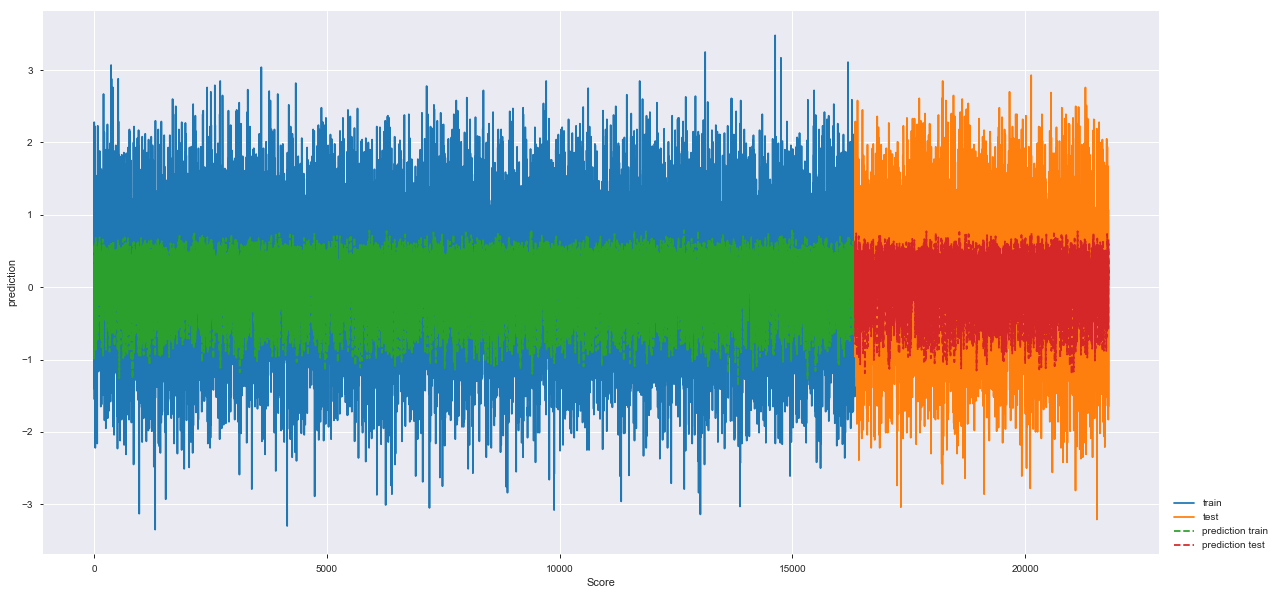

In [690]:
n_train = len(X_train)
import matplotlib.pyplot as plt
#y_pred_train = linreg.predict(X_train)
#y_pred_test = linreg.predict(X_test)
plt.figure(figsize=(20, 10))
plt.plot(range(n_train), y_train, label="train")
plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
plt.plot(range(n_train), y_predictedTrain, '--', label="prediction train")

plt.plot(range(n_train, len(y_test) + n_train), y_predictedTest, '--',
             label="prediction test")
plt.legend(loc=(1.01, 0))
plt.xlabel("Score")
plt.ylabel("prediction")

# Now Rank the Test data results according to the score
here we have the Test input data, the actual value and the predicted value. for the purpose of the ranking exercise we will use the test data and the value predicted by the model 

In [798]:
y_predictedTestDF = pd.DataFrame(y_predictedTest)
y_predictedTestDF  = y_predictedTestDF.rename(columns={0: "Predicted"})
#display((y_predictedTestDF)[0:1])


#print ("X-Test Shape" ,X_test.shape)
#print ("y-Test Predicted Shape" ,y_predictedTestDF.shape)
df_for_ranking = X_test.reset_index()
df_for_ranking = df_for_ranking.merge(y_predictedTestDF, left_index=True, right_index=True)
ranked_df = df_for_ranking.sort_values(by ='Predicted',  ascending=False )
ranked_df = ranked_df.drop("index", axis=1)
ranked_df = ranked_df.reset_index()
ranked_df = ranked_df.drop("index", axis=1)

display((ranked_df)[0:5])
print (ranked_df.shape)

,race,sex,LSAT,UGPA,region_first_FW,region_first_GL,region_first_MS,region_first_MW,region_first_Mt,region_first_NE,region_first_NG,region_first_NW,region_first_PO,region_first_SC,region_first_SE,Predicted
0,0,1,48.0,4.2,1,0,0,0,0,0,0,0,0,0,0,0.773364
1,0,0,47.0,3.9,0,0,0,0,0,0,0,0,0,1,0,0.773038
2,0,0,46.0,3.9,0,0,0,0,0,0,0,1,0,0,0,0.763601
3,0,0,48.0,4.1,0,0,0,0,0,1,0,0,0,0,0,0.752768
4,0,0,48.0,4.0,0,0,0,0,0,0,1,0,0,0,0,0.752473


(5448, 16)


# Analise with IBM 360

https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb
https://arxiv.org/pdf/1908.00176.pdf
https://5harad.com/papers/fair-ml.pdf


Notes "Fairness is a complex concept, with a number of different possible definitions. We consider group fairness with respect to membership in a protected group, based, for example, on minority race or underrepresented gender, where group membership is readily ascertained by looking at an attribute value. For a given rank cut-off point k, we wish to ensure that the number of protected group members ranked among the top-$k$ is proportional to their representation in the entire population, or to their desired proportion in the output (as is the case in affirmative action interventions)."


To-Do
#Create new protected attributes based on a combination of the other protected 
            #attributes so for example if you belong to the protected Group A of Attribute A
            #and protected grouo B of attribute B then you are in a double protected group
            #In order to achieve this we must provide the possibility of identifying 
            #the protected group for each protected attribute.
            
            #df['multi_protected'] = df.apply(lambda row: row.a and row.b, axis=1)   


https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6
    

In [821]:
class review_fairness_UI():

    def __init__(self, **kwargs):

        self.ranked_df = kwargs['ranked_df']
        self.protected_attributes = kwargs['protected_attributes']
        self.group_names = kwargs['group_names']
        self.renamed_groups = kwargs['renamed_groups']

        self.high_ranking_positive = kwargs['high_ranking_positive']
        self.HIGH_RANGE_POSITIVE = 1
        if self.high_ranking_positive == False:
            self.HIGH_RANGE_POSITIVE = 0

        self.style = {'description_width': 'initial'}
        self.layout = {'width': '700px'}
        self.layout_short = {'width': '300px'}

        # Either upload the file or create the class with pandas Dataframe as input
        self.fileUploader = FileUpload(accept='.csv',
                                       multiple=False,
                                       disabled=False,
                                       style_button='color: darkblue; background-color: lightsalmon; width: 180px;',
                                       compress_level=9
                                       )

        # self.fileUploader.observe(self.on_new_file_upload, names='value')

        self.selectYAttribute = widgets.Dropdown(
            options=self.ranked_df.columns.values,
            value="Predicted",
            description='Ranked Output:',
            disabled=False,
            style=self.style,
            layout=self.layout
        )

        self.selectImpact = widgets.RadioButtons(
            options={'A Positive impact on the the life of the individual': 1,
                     'A negative impact on the the life of the individual': 0},
            description='For decisions, a high rank will results in:',
            disabled=False,
            layout=self.layout,
            style=self.style,
            value=self.HIGH_RANGE_POSITIVE
        )

        self.percentOrTopK = widgets.RadioButtons(
            options={'Top-K results': 1,
                     'Top-X percent of results': 0},
            description='For analysis use:',
            disabled=False,
            layout=self.layout,
            style=self.style,
            value=1
        )

        def on_impact_selected(change):
            if (change['new'] == 1):
                self.HIGH_RANGE_POSITIVE = 1
            if (change['new'] == 0):
                self.HIGH_RANGE_POSITIVE = 0
            self.view_protected(
                self.selectProtectedAttributes.value, self.selectYAttribute.value)

        self.selectImpact.observe(on_impact_selected, names='value')

        # use to define the selected attributes, one or more
        self.selectProtectedAttributes = widgets.SelectMultiple(
            options=self.ranked_df.columns.values,
            value=self.protected_attributes,
            description='Protected Attribute(s)',
            disabled=False,
            style=self.style,
            layout=self.layout
        )

        # use to select the protected attribute to examine
        self.selectProtectedAttributeToExamine = widgets.Dropdown(
            options=self.protected_attributes,
            description='Protected Attributes',
            disabled=False,
            style=self.style,
            layout=self.layout
        )

        self.choosen_attribute_values = widgets.SelectMultiple(
            description='Select attribute value',
            disabled=False,
            style=self.style,
            layout=self.layout_short
        )

        self.selectFairnessMeasure = widgets.Dropdown(
            options=['Counterfactual fairness', 'Equality of outcome', '3'],
            # rows=10,
            description='Select the definition of fairness that best applies',
            disabled=False,
            style=self.style,
            layout=self.layout
        )

        # Exposure Drop Measure - Relating to the concept of uneven distribution of attention
        self.selectExpDropMeasure = widgets.Dropdown(
            options={'Standard logarithmic discount':1, 'Geometric Distribution (TBD)':2, 'Viable-n test(TBD)':3},
            # rows=10,
            description='Exposure Drop-off(Position Bias)',
            disabled=False,
            style=self.style,
            layout=self.layout
        )

        self.selectPercentageOfResults = widgets.Dropdown(
            options=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            # rows=10,
            description='Top-X percent of results: ',
            disabled=False,
            style=self.style,
            layout=self.layout
        )

        self.selectTopKResults = widgets.IntText(
            value=20,
            description='Top-K results:            ',
            disabled=False,
            style=self.style,
            layout=self.layout,
            max=1000,
            min=0,
        )



        self.outUploadData = widgets.interactive_output(self.upload_data, {
            'fileUploader_value': self.fileUploader})

        self.outSelectProtected = widgets.interactive_output(self.select_protected, {
            'selectProtectedAttributes_values': self.selectProtectedAttributes})

        self.outSelectRankedListCol = widgets.interactive_output(self.select_ranked_column, {
            'selectYAttribute_values': self.selectYAttribute})

        self.viewProtectedOut = widgets.interactive_output(self.view_protected, {
            'selectProtectedAttributes_values': self.selectProtectedAttributes,
            'selectYAttribute_values': self.selectYAttribute})

        self.viewAnalysisOut = widgets.interactive_output(self.run_analysis, {
            'selectProtectedAttributes_value': self.selectProtectedAttributes,
            'selectProtectedAttributeToExamine_value': self.selectProtectedAttributeToExamine,
            'selectPercentageOfResults_value': self.selectPercentageOfResults,
            'selectExpDropMeasure_value': self.selectExpDropMeasure,
            'selectTopKResults_value': self.selectTopKResults,
            'percentOrTopK_value': self.percentOrTopK})

        self.viewAnalysisGroupPercentInPop = widgets.Output(layout={})
        
        
        self.viewListInfoOut = widgets.Output(layout={})
        self.viewProtectedPandasPlotA = widgets.Output(layout={})
        self.viewProtectedPandasPlotB = widgets.Output(layout={})
        

        # to populate the UI at startup - add this to a method later
        self.select_protected(self.selectProtectedAttributes.value)
        self.select_ranked_column(self.selectYAttribute.value)
        self.view_protected(self.selectProtectedAttributes.value, self.selectYAttribute.value)
        self.run_analysis(
                     self.selectProtectedAttributes.value,
                     self.selectProtectedAttributeToExamine.value,
                     self.selectPercentageOfResults.value,
                     self.selectExpDropMeasure.value,
                     self.selectTopKResults.value,
                     self.percentOrTopK.value
                     )

    def upload_data(self, fileUploader_value):
        if not(self.ranked_df.empty):
            display("Ranked list already imported")
            display(self.ranked_df.head(5))
        try:
            for key in fileUploader_value:
                print("File uploaded: ",
                      fileUploader_value[key]['metadata']['name'])
                try:
                    csvInBytes = fileUploader_value[key]['content']
                    s = str(csvInBytes, 'utf-8')
                    data = StringIO(s)
                    self.ranked_df = pd.read_csv(data)
                    csvInBytes = 0
                    data = 0
                    s = 0
                    print("")
                    print("Snapshot of unmodified data set")
                    display(self.ranked_df.head(5))
                except:
                    print("Error reading file - upload new file")
        except:
            print("Error uploading file - upload again")

    
    def select_protected(self, selectProtectedAttributes_values):
        try:
            with self.outSelectProtected:
                clear_output(wait=True)
                display(HTML("<b><font color='blue'> Protected Attributes </b> </font>"),
                        selectProtectedAttributes_values)                           
            
        except:
            display("Protected attributes not yet set")

    
    
    def select_ranked_column(self, selectYAttribute_values):
        try:
            with self.outSelectRankedListCol:
                clear_output(wait=True)
                display(HTML(
                    "<b><font color='blue'> Ranked output column </b> </font>"), selectYAttribute_values)

        except:
            display("Ranked column not yet set")

   
    def view_protected(self, selectProtectedAttributes_values, selectYAttribute_values):
        %matplotlib inline
        protected = []
        protectedCount = []
        protectedPercentage = []

        try:
            with self.viewProtectedOut:
                clear_output(wait=True)
                colType = self.ranked_df[selectYAttribute_values].dtype
                if (colType != str and colType != object):
                    yMin = self.ranked_df[selectYAttribute_values].min()
                    yMean = self.ranked_df[selectYAttribute_values].mean()
                    yMax = self.ranked_df[selectYAttribute_values].max()

                    bins = [yMin, yMean, yMax]
                    
                    yMin = round(yMin, 3)
                    yMean = round(yMean, 3)
                    yMax = round(yMax, 3)              
                    newColName = selectYAttribute_values + "-range"
                    names = ['', '']
                    
                    
                    if self.selectImpact.value == 0:
                        names = ['Pos_Outcome', 'Neg_Outcome']

                    if self.selectImpact.value == 1:
                        names = ['Neg_Outcome', 'Pos_Outcome']

                    self.ranked_df[newColName] = pd.cut(
                        self.ranked_df[selectYAttribute_values], bins, labels=names)

                    x = "<br>* Output '" + \
                        str(selectYAttribute_values) + "' grouped in range:"
                    display(HTML("<b>" + str(x) + "</b>"))
                    display(HTML(
                        "Below average utility is defined as Min to Mean value = " + str(yMin) + " to " + str(yMean)))
                    display(HTML(
                        "Above average utility defined as Mean to Max value = " + str(yMean) + " to " + str(yMax)))
                    display(HTML("<br><b>* Impact:</b>"))
                    if self.HIGH_RANGE_POSITIVE == 1:
                        impactTxt = "<b>positive</b>"
                    if self.HIGH_RANGE_POSITIVE == 0:
                        impactTxt = "<b>negative</b>"
                    x = "The Impact of a high ranking on an individual or group is " + impactTxt
                    display(HTML(str(x)))
                    display(HTML("<br><b>* Analysis of protected attributes:</b>"))

                    # Print the dictionary nicely
                    display(self.group_names)
                    # display(self.renamed_groups)
                    # see https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
                    for feature in selectProtectedAttributes_values:
                        # print(feature.upper(), ':')
                        protected.append(feature)
                        # protectedCount and protectedPercentage are array of type pd.Series
                        protectedCount.append(
                            self.ranked_df[feature].value_counts())
                        protectedPercentage.append(
                            self.ranked_df[feature].value_counts(normalize=True) * 100)

                    if (len(protected) > 0):

                        for (PDSeries, PDSeriesPcnt, PDName) in zip(protectedCount, protectedPercentage, protected):
                            PDSeries.plot.pie(figsize=(5, 5))
                            plt.xlabel(PDSeries.name)
                            plt.ylabel("frequency")
                            df = pd.DataFrame(
                                dict(Count=PDSeries, Percentage=PDSeriesPcnt)).reset_index()
                            df = df.rename(
                                columns={"index": PDName.capitalize()})
                            df = df.style.set_properties(**{'background-color': 'black',
                                                            'color': 'lawngreen',
                                                            'border-color': 'white'})

                            display(HTML("<b><font color='blue'>" +
                                         PDName + ":</b></font>"))
                            display("Representation in the full ranked list")
                            display(df)
                            plt.show()
                            display(
                                "Distribution of outcome in the full ranked list")
                            pd.crosstab(self.ranked_df[PDName], self.ranked_df[newColName]).plot.bar(
                                stacked=False, figsize=(5, 5))

                            plt.xlabel(PDName)
                            plt.ylabel(newColName)
                            plt.show()

            if (colType == str or colType == object):
                print("Output label is not a number and should be converted")
        except:
            print("**Protected groups visualization not yet generated**")

    def run_analysis(self,
                     selectProtectedAttributes_value,
                     selectProtectedAttributeToExamine_value,
                     selectPercentageOfResults_value,
                     selectExpDropMeasure_value,
                     selectTopKResults_value,
                     percentOrTopK_value
                     ):
        expList = []

        local_ranked_df = self.ranked_df.copy()
        allGroupsInProtected = local_ranked_df[selectProtectedAttributeToExamine_value].unique()
        result = self.group_names[selectProtectedAttributeToExamine_value]
        try:
            with self.viewListInfoOut:
                clear_output(wait=True)
                textOne = 'Total number of records in ranked list (n) = ' + str(len(local_ranked_df))
                textTwo ='Note: when n is sufficiently small we expect the user to read all results or for all outcomes to be equal'
                display(HTML("<font color='blue'>" + textOne + " </font>"))
                display(HTML("<font color='blue'>" + textTwo + " </font>"))
                
        except:
            display ('Data not yet loaded')
        
        dictOfSliders = {}
        try:
            with self.viewAnalysisGroupPercentInPop:
                clear_output(wait=True)
    
                try:
                    for group in allGroupsInProtected:
                        #print (group)
                        #print (result[str(group)])
                        desc = str(group) + " : " + str(result[str(group)]) + ": Set proportion of population"
                        #listOfSliders.append()
                        dictOfSliders[group] = widgets.IntSlider(
                                value=5,
                                description= desc ,
                                max=100,
                                min=0,
                                style=self.style,
                                layout=self.layout)
                
                except:
                    for group in allGroupsInProtected:
                        #print (group)
                        #print (result[group])
                        desc = str(group) + " : " + str(result[group]) + ": Proportion of population"
                        dictOfSliders[group] = widgets.IntSlider(
                                value=5,
                                description= desc ,
                                max=100,
                                min=0,
                                style=self.style,
                                layout=self.layout)
                    for group in allGroupsInProtected:
                        display (dictOfSliders[group])
        except:
            print("output not generated yet")
            
            
        # PUT IF Statement here to deal with all 3  possible Exposure calculations
        #Calculate the Logrithmic discount exposure drop off for the entire dataset
        for x in range(len(local_ranked_df)):
            # For each record add the exposure to a pandas Series
            exposure=1/math.log(x+2, 2)
            expList.append(exposure)
            
        # Now we have a full list with the "logarithmic discount" exposure
        local_ranked_df.insert(0, "exposure", expList, True)
        
        adjustment = 0
        lowestUtil = self.ranked_df[self.selectYAttribute.value].min()
        
        if (lowestUtil < 0):
            try:
                with self.viewAnalysisOut:
                    display("Utilities adjusted by " + str(lowestUtil) + " to ensure no negative numbers in exp/util" )
            except:
                display ("self.viewAnalysisOut not yet created")
            adjustment = lowestUtil
            local_ranked_df['Predicted'] = local_ranked_df['Predicted'].apply(lambda x: x-adjustment)
        
        #Create a small data frame containing the average exposure and utility
        fullExp_util=local_ranked_df.groupby(selectProtectedAttributeToExamine_value).mean()[
            ['exposure', 'Predicted']]
        
        fullExp_util['exposure_over_utility']=fullExp_util.apply(
            lambda row: row.exposure/row.Predicted, axis=1)
        
        fullExp_util.rename(columns={'Predicted':'utility'}, inplace=True)
        
        try:
            with self.viewAnalysisOut:
                display ("Full dataset:")
                display(fullExp_util)
        except:
            display ("no data")
        
        if self.percentOrTopK.value == 0:
        # Now reduce the ranked list based on whethere we are using percentage or top k
            resultsLen=round(len(local_ranked_df) *selectPercentageOfResults_value/100)
        if self.percentOrTopK.value == 1:
        # Now reduce the ranked list based on whethere we are using percentage or top k
            resultsLen= self.selectTopKResults.value
        try:
            with self.viewAnalysisOut:
                display()
                display("List reduced to top:" + str (resultsLen))
        except:
            display ("no data")
        # Create a ranked list of only the "top" records.
        ranked_df_top=local_ranked_df.head(resultsLen).copy()

        reducedExp_util=ranked_df_top.groupby(selectProtectedAttributeToExamine_value).mean()[
            ['exposure', 'Predicted']]
        reducedExp_util['exposure_over_utility']=reducedExp_util.apply(
            lambda row: row.exposure/row.Predicted, axis=1)
        
        reducedExp_util.rename(columns={'Predicted':'utility'}, inplace=True)
        try:
            with self.viewAnalysisOut:
                display(reducedExp_util)
        except:
            display ("no data")
        
        self.view_protected_attribute (ranked_df_top, selectProtectedAttributeToExamine_value )
        
            
    def view_protected_attribute(self, ranked_df_top_k, selectProtectedAttributeToExamine_value):
        try:
            with self.viewAnalysisOut:
        
                protected = []
                protectedCount = []
                protectedPercentage = []
                colType = ranked_df_top_k[self.selectYAttribute.value].dtype
        
                if (colType != str and colType != object):
                    yMin = self.ranked_df[self.selectYAttribute.value].min()
                    yMean = self.ranked_df[self.selectYAttribute.value].mean()
                    yMax = self.ranked_df[self.selectYAttribute.value].max()
                    
                    #As it is -value in this case - - = +
                    if (yMin < 0):
                        adjust = yMin
                        yMin = yMin - adjust
                        yMean = yMean - adjust
                        yMax = yMax - adjust
                        
                    bins = [yMin, yMean, yMax]
            
                    yMin = round(yMin, 3)
                    yMean = round(yMean, 3)
                    yMax = round(yMax, 3)
            
            
                    newColName = self.selectYAttribute.value + "-range" 
                    names = ['', '']
            
            
                    if self.selectImpact.value == 0:
                        names = ['Pos_Outcome', 'Neg_Outcome']

                    if self.selectImpact.value == 1:
                        names = ['Neg_Outcome', 'Pos_Outcome']
            
                    ranked_df_top_k[newColName] = pd.cut(ranked_df_top_k[self.selectYAttribute.value], bins, labels=names).copy()
                    # if utility is a negative value add the minimum value to all values to make positive
                    
                    display(HTML("Below average utility is defined as Min to Mean value of entire data set = " + str(yMin) + " to " + str(yMean)))
                    display(HTML("Above average utilityutility is defined as Mean to Max value of entire data set= " + str(yMean) + " to " + str(yMax)))
                    display(HTML("<br><b>* Impact:</b>"))
            
                    if self.HIGH_RANGE_POSITIVE == 1:
                        impactTxt = "<b>positive</b>"
                    if self.HIGH_RANGE_POSITIVE == 0:
                        impactTxt = "<b>negative</b>"
                    x = "The Impact of a high ranking on an individual or a group is " + impactTxt
                    display(HTML(str(x)))
                    display(HTML("<br><b>* Analysis of protected attributes:</b>"))

                    display(self.group_names)

                    feature = selectProtectedAttributeToExamine_value
                    # print(feature.upper(), ':')
                    protected.append(feature)
                    # protectedCount and protectedPercentage are array of type pd.Series
                    protectedCount.append(ranked_df_top_k[feature].value_counts())
                    protectedPercentage.append(ranked_df_top_k[feature].value_counts(normalize=True) * 100)
                    count = 0
                    if (len(protected) > 0):

                        for (PDSeries, PDSeriesPcnt, PDName) in zip(protectedCount, protectedPercentage, protected):
                            #Create a Dataframe to display the attribute stats
                            df = pd.DataFrame(dict(Count=PDSeries, Percentage=PDSeriesPcnt)).reset_index()
                            df = df.rename(columns={"index": PDName.capitalize()})
                            df = df.style.set_properties(**{'background-color': 'black',
                                                            'color': 'lawngreen',
                                                            'border-color': 'white'})

                            #Create a Dataframe to display the attribute stats
                            display(HTML("<b><font color='blue'>Analysis of '" + PDName + "' in reduced ranked list:</b></font>"))
                            display(df)
                            

                            with self.viewProtectedPandasPlotA:
                                clear_output(wait=True)
                                PDSeries.plot.pie(figsize=(5, 5), title="Representation in reduced list")
    
                            
                            with self.viewProtectedPandasPlotB:
                                clear_output(wait=True)
                                pd.crosstab(ranked_df_top_k[PDName], ranked_df_top_k[newColName]).plot.bar(stacked=False, figsize=(5, 5), title="Distribution of outcome in reduced list")
                                

                if (colType == str or colType == object):
                    print("Output label is not a number and should be converted")
        except: 
            display("content not yet loaded")
 

        
    def render(self):
        space=widgets.Label('  ', layout=widgets.Layout(width='100%'))

        uploadFileHTML=widgets.HTML(
            "<h3><left>1. Upload Ranked list:</left></h3>")

        setRankedOutputHTML=widgets.HTML(
            "<h3><left>2. Identify the ranked output column:</left></h3>")

        effectOfRankingHTML=widgets.HTML(
            "<h4><left>Set the effect of ranking on the individual or group</left></h4>")

        setProtectedAttributesHTML=widgets.HTML(
            "<h3><left>3. Identify the protected attributes column:</left></h3>")

        visualiseProtectedAttributesHTML=widgets.HTML(
            "<h3><left>4. Visualise protected attributes:</left></h3>")

        analyzeProtectedHTML=widgets.HTML(
            "<h3><left>5. Analyze ranking for fairness:</left></h3>")

        analyzeProtectedHTML_B=widgets.HTML(
            "<h4><left>Specify the number of results that will receive attention:</left></h4>")

        analyzeProtectedHTML_C=widgets.HTML(
            "<h4><left>Specify the protected attribute to analyse:</left></h4>")

        JoacmAndSinghHTML=widgets.HTML(
            "<h4><left>Joachim and Singh:</left></h4>")
        
        FAIRHTML=widgets.HTML(
            "<h4><left>FA*IR:</left></h4>")


        display(
            uploadFileHTML,
            self.fileUploader,
            self.outUploadData,
            space,
            setRankedOutputHTML,
            self.selectYAttribute,
            self.outSelectRankedListCol,
            space,
            effectOfRankingHTML,
            self.selectImpact,
            space,
            setProtectedAttributesHTML,
            self.selectProtectedAttributes,
            self.outSelectProtected,
            space,
            visualiseProtectedAttributesHTML,
            self.viewProtectedOut,

            space,

            analyzeProtectedHTML,

            # view_analysis input fields
            widgets.VBox([
                self.viewListInfoOut,
                space,
                analyzeProtectedHTML_B,
                self.selectTopKResults,
                self.selectPercentageOfResults,
                space,
                self.percentOrTopK,
                space,
                analyzeProtectedHTML_C,
                self.selectProtectedAttributeToExamine,
                self.viewAnalysisGroupPercentInPop,
                space,
                JoacmAndSinghHTML,
                self.selectExpDropMeasure,
                self.viewAnalysisOut,
                widgets.HBox([self.viewProtectedPandasPlotA,
                self.viewProtectedPandasPlotB]),
                space,
                FAIRHTML,
            ]))

HTML(value='<h3><left>1. Upload Ranked list:</left></h3>')

FileUpload(accept='.csv', compress_level=9, style_button='color: darkblue; background-color: lightsalmon; widt…

Output()

Label(value='  ', layout=Layout(width='100%'))

HTML(value='<h3><left>2. Identify the ranked output column:</left></h3>')

Dropdown(description='Ranked Output:', index=15, layout=Layout(width='700px'), options=('race', 'sex', 'LSAT',…

Output()

Label(value='  ', layout=Layout(width='100%'))

HTML(value='<h4><left>Set the effect of ranking on the individual or group</left></h4>')

RadioButtons(description='For decisions, a high rank will results in:', layout=Layout(width='700px'), options=…

Label(value='  ', layout=Layout(width='100%'))

HTML(value='<h3><left>3. Identify the protected attributes column:</left></h3>')

SelectMultiple(description='Protected Attribute(s)', index=(0, 1), layout=Layout(width='700px'), options=('rac…

Output()

Label(value='  ', layout=Layout(width='100%'))

HTML(value='<h3><left>4. Visualise protected attributes:</left></h3>')

Output()

Label(value='  ', layout=Layout(width='100%'))

HTML(value='<h3><left>5. Analyze ranking for fairness:</left></h3>')

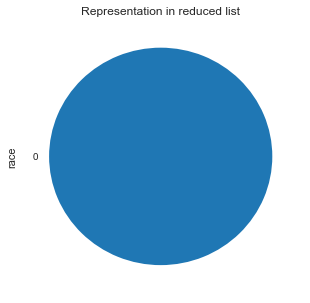

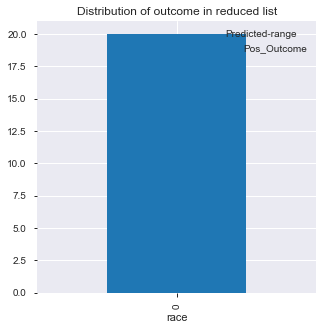

In [822]:
protected_attributes, renamed_groups, group_names = dpUI.get_protected()
high_ranking_positive = dpUI.high_positive ()
fairness = review_fairness_UI(ranked_df=ranked_df, protected_attributes=protected_attributes, renamed_groups=renamed_groups,high_ranking_positive=high_ranking_positive, group_names = group_names)
fairness.render()

# THE END

# Logistic Regression - Classification
Is a popular statistical model used for binary classification, that is for predictions of the type this or that, yes or no, A or B, etc.

Above or below a treshold for example


In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

In [ ]:
def weightInitialization(n_features):
    w = np.zeros((1,n_features))
    b = 0
    return w,b


def sigmoid_activation(result):
    final_result = 1/(1+np.exp(-result))
    return final_result


def model_optimize(w, b, X, Y):
    print ("in model_optimize")
    print("weights", w)
    print("bias", b)
    m = X.shape[0]  
    print("X.shape", m)
    print("X.T", X.T)
    #Prediction
    #Prediction
    final_result = sigmoid_activation(np.dot(w,X.T)+b)
    print ("final_result", final_result)
    Y_T = Y.T
    cost = (-1/m)*(np.sum((Y_T*np.log(final_result)) + ((1-Y_T)*(np.log(1-final_result)))))
    #
    print ("cost", cost)
    #Gradient calculation
    dw = (1/m)*(np.dot(X.T, (final_result-Y.T).T))
    db = (1/m)*(np.sum(final_result-Y.T))
    grads = {"dw": dw, "db": db}
    return grads, cost


def model_predict(w, b, X, Y, learning_rate, no_iterations):
    print('in model-predict')
    print("weights", w)
    print("bias", b)
    print("learning_rate", learning_rate)
    print("no_iterations", no_iterations)
    costs = []
    for i in range(no_iterations):
        #
        grads, cost = model_optimize(w,b,X,Y)
        print('Grads', grads)
        print('cost', cost)
        #
        dw = grads["dw"]
        db = grads["db"]
        #weight update
        w = w - (learning_rate * (dw.T))
        b = b - (learning_rate * db)
        #
        
        if (i % 100 == 0):
            costs.append(cost)
            #print("Cost after %i iteration is %f" %(i, cost)) 
    #final parameters
    coeff = {"w": w, "b": b}
    gradient = {"dw": dw, "db": db}  
    return coeff, gradient, costs


def predict(final_pred, m):
    y_pred = np.zeros((1,m))
    for i in range(final_pred.shape[1]):
        if final_pred[0][i] > 0.5:
            y_pred[0][i] = 1
    return y_pred

